In [1]:
import numpy as np
from pr3_utils import *
from stereo import *

In [56]:
dataset = "03"
time_stamp,features,linear_velocity,angular_velocity,K,b,imu_T_cam = load_data(f"../data/{dataset}.npz")

num_time_stamp = time_stamp.shape[0]
num_features = features.shape[1]

tau = time_stamp[1:] - time_stamp[:-1]
velocity = np.concatenate([linear_velocity, angular_velocity], axis=1)

T_mean = np.load(f"../data/predict_T_mean_{dataset}.npy")
T_covar = np.load(f"../data/predict_T_covar_{dataset}.npy")

M_init, seen_mask = get_M_init(features, T_mean, K, b, imu_T_cam)

In [17]:
opt_T_cam = np.array([
    [0,-1, 0,0],
    [0, 0,-1,0],
    [1, 0, 0,0],
    [0, 0, 0,1],
])
opt_T_imu = opt_T_cam @ np.linalg.inv(imu_T_cam)
fsu = K[0,0]
fsv = K[1,1]
cu  = K[0,2]
cv  = K[1,2]
Ks = np.array([
    [fsu,0,cu,0],
    [0,fsv,cv,0],
    [fsu,0,cu,-fsu*b],
    [0,fsv,cv,0],
])
P = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0],
])

In [4]:
def get_seeing_mask(features, d_min = 1, d_max = 40):
    present_mask = np.all(features != -1, axis=1)

    d = features[present_mask, 0] - features[present_mask, 2]
    d_mask = (d_min < d) & (d < d_max)

    present_mask[present_mask] = d_mask
    return present_mask
get_seeing_mask(features[10])

array([ True,  True,  True, ..., False, False, False])

In [55]:
# features_mu = np.zeros([num_features*3])
M_mean = M_init
M_covar = np.eye(3*num_features, 3*num_features)

V = 1
for t in range(1, time_stamp.shape[0]):
    present_mask = get_seeing_mask(features[t,:,:])
    present_M = M_mean[present_mask, :]
    present_M_homo = np.hstack([present_M, np.ones([present_M.shape[0],1])])

    # Iterate over these indices
    Nt = np.sum(present_mask)
    H = np.zeros([Nt, 4, num_features, 3])
    tt = opt_T_imu @ np.linalg.inv(T_mean[t])
    for j,i in enumerate(np.where(present_mask)[0]):
        H[j,:,i,:] = Ks @ \
         projectionJacobian(tt @ present_M_homo[j,:]) @ \
         tt@P.T
    H = H.reshape([Nt*4, num_features*3])    
    K = M_covar @ H.T @ np.linalg.inv(H @ M_covar @ H.T + V*np.eye(Nt*4))
    
    print(M_mean.shape)
    innovation = features[t,present_mask,:] - (Ks@projection((tt @ present_M_homo.T))).T
    M_mean = (M_mean.reshape(-1) + K @ innovation.reshape(-1)).reshape(-1, 3)
    M_covar = (np.eye(num_features* 3) - K@H)@M_covar
    break

(5105, 3)


/Users/weixiaozhan/GradSchool/24WT/ECE276A_SensingEstimationRobotics/PR3/code/pr3_utils.py:88: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x,y,'r-',label=path_name, c="C0")


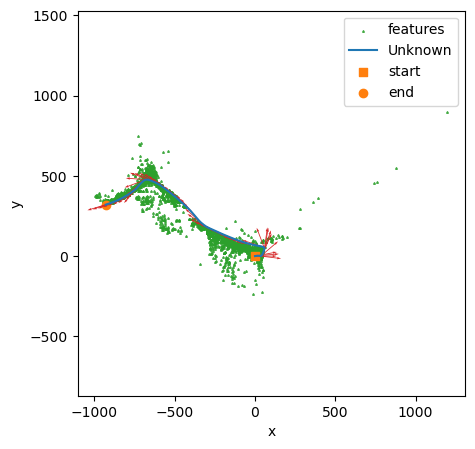

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

In [58]:
visualize_trajectory(T_mean, features=M_mean)

/Users/weixiaozhan/GradSchool/24WT/ECE276A_SensingEstimationRobotics/PR3/code/pr3_utils.py:88: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x,y,'r-',label=path_name, c="C0")


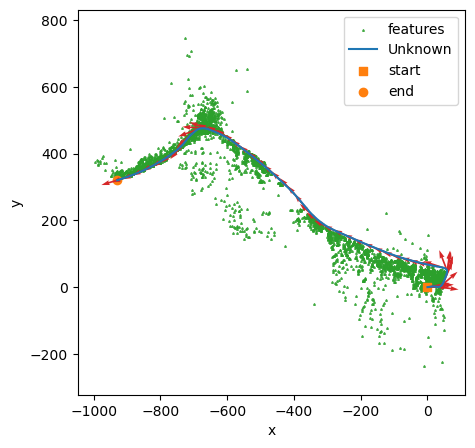

(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='x', ylabel='y'>)

In [59]:
visualize_trajectory(T_mean, features=M_init)

In [22]:
# f = np.arange(6).reshape(2,3)
# print(f, f.reshape(-1,1))

cov = np.arange(36).reshape(2,3,2,3)
cov_full = cov.reshape(6,6)
print(cov_full)
cov[1,:,1,:]

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]
 [30 31 32 33 34 35]]


array([[21, 22, 23],
       [27, 28, 29],
       [33, 34, 35]])